In [3]:
import torch
import numpy as np
import sys
import torchvision
from torchvision import transforms
import torch.utils.data as Data
# 数据集继续使用 Fasion-MNIST
# 使用多层感知机对图像进行分类
batch_size = 256
mnist_train = torchvision.datasets.FashionMNIST(root='/Users/milktime/AnacondaProjects/deeplearning/Datasets/FashionMNIST', \
    train=True, download=False, transform=transforms.ToTensor())
mnist_test = torchvision.datasets.FashionMNIST(root='/Users/milktime/AnacondaProjects/deeplearning/Datasets/FashionMNIST', \
    train=False, download=False, transform=transforms.ToTensor())
num_workers = 4
train_iter = Data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_iter = Data.DataLoader(mnist_test, batch_size=batch_size, shuffle=True, num_workers=num_workers)


# MLP模型示意图
![avatar](https://tangshusen.me/Dive-into-DL-PyTorch/img/chapter03/3.8_mlp.svg) <br>
有多层，但由于每一层都是全连接（线性），因此，最终的多层网络结构整体上仍然是线性的
所以要在每一层后面加上激活函数，常见的激活函数有 `ReLU` `Sigmoid` `tanh` 可求偏导，作用在输出结果，然后作为下一层的输入


epoch 1, loss 0.0032, train acc 0.698, test acc 0.765
epoch 2, loss 0.0019, train acc 0.818, test acc 0.806
epoch 3, loss 0.0016, train acc 0.844, test acc 0.839
epoch 4, loss 0.0015, train acc 0.854, test acc 0.844
epoch 5, loss 0.0015, train acc 0.863, test acc 0.770


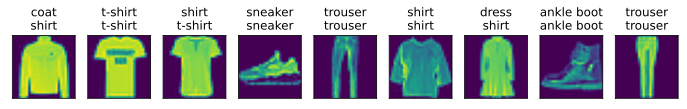

In [4]:
# 定义模型参数
# 设置 超参数 隐藏层单元数为 256
num_inputs, num_outputs, num_hiddens = 784, 10, 256

W1 = torch.tensor(np.random.normal(0, 0.01, (num_inputs, num_hiddens)), dtype=torch.float)
b1 = torch.zeros(num_hiddens, dtype=torch.float)
W2 = torch.tensor(np.random.normal(0, 0.01, (num_hiddens, num_outputs)), dtype=torch.float)
b2 = torch.zeros(num_outputs, dtype=torch.float)

params = [W1, b1, W2, b2]
for param in params:
    param.requires_grad_(requires_grad=True)

# 定义激活函数
# out_i = max(tensor_i, other_i)
def relu(X):
    # 利用广播机制，X的每一个元素和0比较，取最大值
    return torch.max(input=X, other=torch.tensor(0.0))

# 定义模型
def net(X):
    # the shape of X is (batch_size, 1, 28, 28)
    X = X.view(-1, num_inputs)
    H = relu(torch.mm(X, W1) + b1)
    return torch.mm(H, W2) + b2

# 定义损失函数
# 因为是多分类器，所以使用cross entropy
# loss 是 每个训练样本的平均 loss，已经除过 batch_size了
# pytorch库的 crossentropy集成了 softmax + CrossEntropy
loss = torch.nn.CrossEntropyLoss()

# 实现梯度下降优化函数
def sgd(params, lr):
    for param in params:
        # 注意这里用的是 param.data，避免干扰自动计算的梯度
        param.data -= lr * param.grad

# 评估 网络模型 net 上，测试集的准确率
def evaluate_accuracy(data_iter, net):
    acc_sum, n = 0.0, 0
    for X, y in data_iter:
        y_hat = net(X)
        acc_sum += (y_hat.argmax(dim=1) == y).sum()
        n += X.shape[0]
    return acc_sum / n


# 训练模型
num_epochs, lr = 5, 0.5
for epoch in range(num_epochs):
    train_l_sum, train_acc_sum, n = 0.0, 0.0, 0
    for X, y in train_iter:
        # 每个batch 的样本标签 组成1维向量
        y_hat = net(X)
        l = loss(y_hat, y)
        l.backward() # 计算梯度
        sgd(params, lr) # 梯度下降优化
        for param in params:
            param.grad.data.zero_() # 清空梯度
        train_l_sum += l.item()
        train_acc_sum += (y_hat.argmax(dim=1) == y).sum().item()
        n += X.shape[0]
    test_acc = evaluate_accuracy(test_iter, net)
    print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f'
              % (epoch + 1, train_l_sum / n, train_acc_sum / n, test_acc))


# 画图
from IPython import display
from matplotlib import pyplot as plt
# 下面两个函数画图相关
def use_svg_display():
    display.set_matplotlib_formats('svg')

def set_figsize(figsize=(3.5, 2.5)):
    use_svg_display()
    plt.rcParams['figure.figsize'] = figsize

# 将数值标签 转换为 相应的文本标签
def get_fashion_mnist_labels(labels):
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

def show_fashion_mnist(images, labels):
    use_svg_display()
    # 这里的_ 表示我们忽略（不使用）的变量
    _, figs = plt.subplots(1, len(images), figsize=(12, 12))
    for f, img, lbl in zip(figs, images, labels):
        f.imshow(img.view((28, 28)).numpy())
        f.set_title(lbl)
        f.axes.get_xaxis().set_visible(False)
        f.axes.get_yaxis().set_visible(False)
    plt.show()

X, y = iter(test_iter).next()
true_labels = get_fashion_mnist_labels(y)
pred_labels = get_fashion_mnist_labels(net(X).argmax(dim=1))
titles = [true + '\n' + pred for true, pred in zip(true_labels, pred_labels)]
show_fashion_mnist(X[0:9], titles[0:9])